In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch
import time

In [2]:
def readfile(path,label):
    '''
    path: path of images
    label: bool, return y or not
    '''
    files = sorted(os.listdir(path))

    X = np.zeros((len(files),128,128,3),dtype=np.uint8)
    y = np.zeros((len(files)),dtype=np.uint8)

    for i,file in enumerate(files):
        img = cv2.imread(os.path.join(path,file))
        X[i] = cv2.resize(img,(128,128))
        if label:
            y[i] = int(file.split("_")[0])
    if label:
        return X,y
    else:
        return X

In [3]:
work_dir = '../input/ml2020spring-hw3/food-11/'

In [4]:

print('Reading data')

X_train, y_train = readfile(os.path.join(work_dir,'training'),True)
print(f'Size of training data {len(X_train)}')

X_val, y_val = readfile(os.path.join(work_dir,'validation'),True)
print(f'Size of validation data {len(X_val)}')


Reading data
Size of training data 9866
Size of validation data 3430


In [5]:
X_test = readfile(os.path.join(work_dir,'testing'),False)
print(f'Size of testing data {len(X_test)}')

Size of testing data 3347


In [6]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class ImgDataSet(Dataset):
    def __init__(self,X,y=None,transform=None):
        self.X = X
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,index):
        x = self.X[index]
        if self.transform is not None:
            x = self.transform(x)
        if self.y is not None:
            y = self.y[index]
            return x,y
        else:
            return x

In [7]:
batch_size = 128

In [8]:
train_set = ImgDataSet(X_train,y_train,train_transform)
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)

val_set = ImgDataSet(X_val,y_val,test_transform)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

Model

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        # input [3,128,128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3,64,3,1,1),   # [64,128,128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),     # [64,64,64]
            
            nn.Conv2d(64,128,3,1,1), # [128,64,64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),     # [128,32,32]
            
            nn.Conv2d(128,256,3,1,1), # [256,32,32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),      # [256,16,16]
            
            nn.Conv2d(256,512,3,1,1), # [512,16,16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),      # [512,8,8]

            nn.Conv2d(512,512,3,1,1), # [512,8,8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0),      # [512,4,4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4,1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512,11)
        )        
        
    def forward(self,x):
        out = self.cnn(x)
        out = out.view(out.shape[0],-1)
        return self.fc(out)

Training

In [28]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

In [29]:
num_epoch = 20

for epoch in range(num_epoch):
    start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred,data[1].cuda())
        batch_loss.backward()
        optimizer.step()
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(),axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred,data[1].cuda())
            
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        train_acc /= train_set.__len__()
        train_loss /= train_set.__len__()
        val_acc /= val_set.__len__()
        val_loss /= val_set.__len__()
        
        cost_time = time.time() - start_time
        print(f'[{epoch+1:03d}/{num_epoch:03d}] {cost_time:2.2f} sec(s) Train Acc: {train_acc:3.6f} Loss: {train_loss:3.6f} | Val Acc: {val_acc:3.6f} Loss: {val_loss:3.6f}')

        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)
        

KeyboardInterrupt: 

In [ ]:
num = len(train_acc_history)

plt.figure()
plt.plot(range(num),train_acc_history,range(num),val_acc_history)
plt.legend(['train','val'])
plt.title('acc')

plt.figure()
plt.plot(range(num),train_loss_history,range(num),val_loss_history)
plt.legend(['train','val'])
plt.title('loss')

从val set上看，这个模型表现是比较不错的。现在用所有的数据来train

In [15]:
X_train_val = np.concatenate((X_train,X_val),axis=0)
y_train_val = np.concatenate((y_train,y_val),axis=0)

train_val_set = ImgDataSet(X_train_val,y_train_val,train_transform)
train_val_loader = DataLoader(train_val_set,batch_size=batch_size,shuffle=True)

In [19]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

train_val_acc_history = []
train_val_loss_history = []

num_epoch = 100

for epoch in range(num_epoch):
    start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    
    model.train()
    for i,data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model(data[0].cuda())
        batch_loss = loss(train_pred,data[1].cuda())
        batch_loss.backward()
        optimizer.step()
        
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(),axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    train_acc /= train_val_set.__len__()
    train_loss /= train_val_set.__len__()

    cost_time = time.time() - start_time
    print(f'[{epoch+1:03d}/{num_epoch:03d}] {cost_time:2.2f} sec(s) Train Acc: {train_acc:3.6f} Loss: {train_loss:3.6f}')

    train_val_acc_history.append(train_acc)
    train_val_loss_history.append(train_loss)        

[001/100] 21.14 sec(s) Train Acc: 0.205400 Loss: 0.017959
[002/100] 21.14 sec(s) Train Acc: 0.300090 Loss: 0.015372
[003/100] 21.22 sec(s) Train Acc: 0.352662 Loss: 0.014479
[004/100] 21.12 sec(s) Train Acc: 0.387485 Loss: 0.013785
[005/100] 21.05 sec(s) Train Acc: 0.407341 Loss: 0.013287
[006/100] 21.37 sec(s) Train Acc: 0.442840 Loss: 0.012701
[007/100] 21.05 sec(s) Train Acc: 0.458258 Loss: 0.012319
[008/100] 21.03 sec(s) Train Acc: 0.486236 Loss: 0.011837
[009/100] 21.28 sec(s) Train Acc: 0.494810 Loss: 0.011689
[010/100] 21.13 sec(s) Train Acc: 0.525196 Loss: 0.011127
[011/100] 21.24 sec(s) Train Acc: 0.540915 Loss: 0.010669
[012/100] 21.19 sec(s) Train Acc: 0.556182 Loss: 0.010364
[013/100] 21.17 sec(s) Train Acc: 0.581077 Loss: 0.009783
[014/100] 21.27 sec(s) Train Acc: 0.593035 Loss: 0.009562
[015/100] 21.22 sec(s) Train Acc: 0.604768 Loss: 0.009335
[016/100] 21.12 sec(s) Train Acc: 0.620563 Loss: 0.008889
[017/100] 21.40 sec(s) Train Acc: 0.643051 Loss: 0.008558
[018/100] 21.1

Text(0.5, 1.0, 'loss')

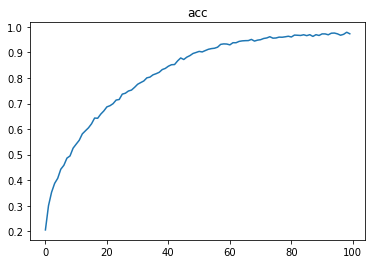

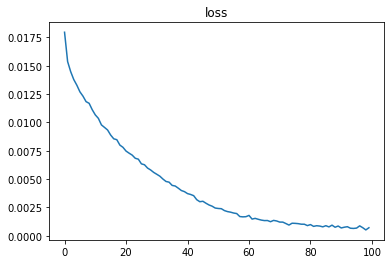

In [20]:
num = len(train_val_acc_history)

plt.figure()
plt.plot(range(num),train_val_acc_history)
plt.title('acc')

plt.figure()
plt.plot(range(num),train_val_loss_history)
plt.title('loss')

Save model

In [25]:
model_pth = 'model_hw3.pth'

torch.save(model.state_dict(),model_pth)

Load model

In [ ]:
# model = Classifier().cuda()
# model.load_state_dict(torch.load('../input/model/model_hw3.pth'))

Testing

In [26]:
test_set = ImgDataSet(X_test,transform=test_transform)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

model.eval()
prediction = []
with torch.no_grad():
    for i,data in enumerate(test_loader):
        test_pred = model(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(),axis=1)
        for y in test_label:
            prediction.append(y)

In [27]:
with open('predict_hw3.csv','w') as f:
    f.write('Id,Category\n')
    for i,y in enumerate(prediction):
        f.write(f'{i},{y}\n')